# Multi-ZMW Subread Analysis with Position Normalization and Mismatch Filtering

## Critical Fix: Mitochondrial Genome Circularization

The mitochondrial genome is **circularized by doubling** the reference for alignment:
- **Actual mtDNA length**: 16,569 bp
- **Circularized reference**: 33,138 bp (16,569 × 2)

**This means position 13,493 appears at TWO locations:**
- Position 13,493 (first copy): some reads align here  
- Position 30,062 (second copy = 13,493 + 16,569): other reads align here

**Solution**: Apply `tpos % CHRM_LENGTH` normalization (as in mismatch_caller.py) to combine reads from both copies.

## NEW: Simplified Mismatch Position Filtering

This notebook **excludes known mismatch positions** from the expected error distribution calculation using a simplified approach:

**Previous approach** (complex):
- ❌ Loaded separate `mismatch.csv` file
- ❌ Built strand mapping dictionary from kinetics file  
- ❌ Converted molecular strand → reference strand → notebook strand
- ❌ ~30 lines of coordinate conversion logic

**New approach** (simple):
- ✅ Uses `is_mismatch` column directly from kinetics CSV
- ✅ Single source of truth for mismatch data
- ✅ Simpler ref_strand → notebook_strand conversion
- ✅ ~10 lines of clean, maintainable code

The kinetics CSV contains all necessary information (`zmw`, `ref_strand`, `tpos`, `is_mismatch`), eliminating the need for complex multi-file coordination.

## Goals
1. Process all 25 ZMWs from test set
2. Assign subreads to forward/reverse based on alignment quality (NOT read names)
3. **Normalize all positions** to 0-16,568 range
4. **Filter out mismatch positions per-(ZMW, strand)** when calculating expected distribution
5. Calculate per-(ZMW, strand) Hellinger distance with improved baseline
6. Generate 3 key plots with **complete dataset** (50 reads at position 13,493)

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pysam
import edlib
import re
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Parallel processing imports
import os
from multiprocessing import Pool, cpu_count
from functools import partial

# Number of cores (default: use NSLOTS env var or all available)
N_CORES = int(os.environ.get('NSLOTS', cpu_count()))

plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("✓ Setup complete")
print(f"✓ Parallel processing: {N_CORES} cores available")

/opt/conda/envs/subread_env/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.stats import gaussian_kde


✓ Setup complete
✓ Parallel processing: 12 cores available


## 2. Load Data and Define Constants

In [2]:
# Paths
test_dir = Path('testing/2D_dataset/')
output_dir = Path('testing/2D_dataset/output')
hellinger_output_dir = Path('testing/2D_dataset/hellinger_analysis_filtered')

# Create output directory if it doesn't exist
hellinger_output_dir.mkdir(parents=True, exist_ok=True)

ccs_bam_path = test_dir / '2D_5_EcoGII_filtered_ccs_reads.bam'
subreads_bam_path = test_dir / '2D_5_EcoGII_filtered_subreads.bam'
reference_path = test_dir / 'hg38_chrM_circularized_by_doubling.fa'
zmw_list_path = test_dir / '2D_5_EcoGII_bubble_mismatch_zmws_at_13493.csv'

# Kinetics data (contains is_mismatch column for filtering)
kinetics_path = Path('/data/results/step5_anomaly_detection_ipd_v0.5/2D_5_EcoGII/2D_5_EcoGII.kinetics_with_anomalies_all_molecules.csv')

# CRITICAL: Mitochondrial genome circularization constants
CHRM_LENGTH = 16569  # Actual mitochondrial genome length (bp)
# Reference is circularized by doubling: 33,138 bp = 16,569 × 2
# Position normalization: tpos_normalized = tpos % CHRM_LENGTH
# This maps both copies to the same 0-16,568 coordinate range

TARGET_POSITION = 13493  # Position in actual mtDNA (0-16,568 range)
MIN_SUBREAD_IDENTITY = 0.5

# Rolling window configuration
USE_ROLLING_WINDOW = False  # Use local window instead of genome-wide expected distribution
WINDOW_SIZE = 50  # Window size in bp (±n positions around center)
MIN_WINDOW_POSITIONS = 5  # Minimum positions required in window after filtering

# Load reference
with pysam.FastaFile(str(reference_path)) as fasta:
    ref_seq = fasta.fetch(fasta.references[0])

# Load ZMW list
zmw_df = pd.read_csv(zmw_list_path)
zmw_list = zmw_df['zmw'].tolist()

print(f"Reference length: {len(ref_seq):,} bp (circularized = 2 × {CHRM_LENGTH:,} bp)")
print(f"Actual mtDNA length: {CHRM_LENGTH:,} bp")
print(f"Target position (normalized): {TARGET_POSITION} (base: {ref_seq[TARGET_POSITION]})")
print(f"Target position (wrapped): {TARGET_POSITION + CHRM_LENGTH} (base: {ref_seq[TARGET_POSITION + CHRM_LENGTH]})")
print(f"Number of ZMWs: {len(zmw_list)}")
print(f"Expected CCS reads at target: {len(zmw_list) * 2} (25 ZMWs × 2 strands)")
print(f"\nRolling window mode: {'ENABLED' if USE_ROLLING_WINDOW else 'DISABLED'}")
if USE_ROLLING_WINDOW:
    print(f"  Window size: {WINDOW_SIZE} bp (±{WINDOW_SIZE//2} positions)")
    print(f"  Min positions required: {MIN_WINDOW_POSITIONS}")
print(f"\nOutput directory: {hellinger_output_dir.absolute()}")

Reference length: 33,138 bp (circularized = 2 × 16,569 bp)
Actual mtDNA length: 16,569 bp
Target position (normalized): 13493 (base: C)
Target position (wrapped): 30062 (base: C)
Number of ZMWs: 183
Expected CCS reads at target: 366 (25 ZMWs × 2 strands)

Rolling window mode: DISABLED

Output directory: /project/testing/2D_dataset/hellinger_analysis_filtered


## 3. Helper Functions with Position Normalization

In [3]:
def reverse_complement(seq):
    """Return reverse complement of DNA sequence."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
    return ''.join(complement.get(base, 'N') for base in reversed(seq))

def complement(seq):
    """Return complement of DNA sequence."""
    complements = str.maketrans("ATCGN", "TAGCN")
    return seq.translate(complements)


def extract_zmw_from_name(read_name):
    """Extract ZMW number from PacBio read name."""
    parts = read_name.split('/')
    if len(parts) >= 2:
        return int(parts[1])
    return None


def parse_cigar_to_reference_map(cigartuples, reference_start, chrM_length=16569):
    """
    Parse CIGAR to create mapping from query positions to reference positions.
    
    
    Args:
        cigartuples: List of (operation, length) tuples from pysam
        reference_start: Starting reference position
        chrM_length: Actual mitochondrial genome length (default: 16569)
    
    Returns:
        dict: Mapping from query positions to normalized reference positions
    """
    query_to_ref = {}
    query_pos = 0
    ref_pos = reference_start
    
    for op, length in cigartuples:
        if op in [0, 7, 8]:  # M, =, X - consume both
            for i in range(length):
                # CRITICAL: Normalize to actual mtDNA coordinates (0-16,568)
                normalized_pos = ref_pos % chrM_length
                query_to_ref[query_pos] = normalized_pos
                query_pos += 1
                ref_pos += 1
        elif op == 1:  # I - insertion
            for i in range(length):
                query_to_ref[query_pos] = None
                query_pos += 1
        elif op == 2:  # D - deletion
            ref_pos += length
        elif op == 4:  # S - soft clip
            query_pos += length
    
    return query_to_ref


def parse_edlib_cigar_to_positions(cigar, query_seq, ref_start, chrM_length=16569):
    """
    Parse edlib CIGAR string to map query positions to reference positions.
    
    CRITICAL: Normalizes positions to actual mtDNA coordinates (0-16,568) using modulo.
    This is essential because the reference is circularized by doubling (33,138 bp).
    
    Args:
        cigar: Edlib CIGAR string (e.g., "100=5X10I20=")
        query_seq: Query sequence string
        ref_start: Starting reference position
        chrM_length: Actual mitochondrial genome length (default: 16569)
    
    Returns:
        np.array: Array mapping query positions to normalized reference positions (-1 for gaps)
    """
    if not cigar:
        return np.full(len(query_seq), -1, dtype=np.int32)
    
    position_map = np.full(len(query_seq), -1, dtype=np.int32)
    pattern = re.compile(r'(\d+)([=XID])')
    
    query_pos = 0
    ref_pos = ref_start
    
    for match in pattern.finditer(cigar):
        length = int(match.group(1))
        op = match.group(2)
        
        if op in ['=', 'X']:  # Match or mismatch
            for i in range(length):
                if query_pos < len(query_seq):
                    # CRITICAL: Normalize to actual mtDNA coordinates (0-16,568)
                    normalized_pos = ref_pos % chrM_length
                    position_map[query_pos] = normalized_pos
                query_pos += 1
                ref_pos += 1
        elif op == 'I':  # Insertion
            query_pos += length
        elif op == 'D':  # Deletion
            ref_pos += length
    
    return position_map

print("✓ Helper functions defined (with position normalization)")

✓ Helper functions defined (with position normalization)


## 4. Load All CCS Reads and Subreads

In [4]:
# Load ALL CCS reads for our ZMWs
ccs_reads = []
with pysam.AlignmentFile(str(ccs_bam_path), 'rb') as bam:
    for read in bam.fetch():
        zmw = extract_zmw_from_name(read.query_name)
        if zmw in zmw_list:
            # Use SAM flag to determine strand
            strand = 'rev' if read.is_reverse else 'fwd'
            
            ccs_reads.append({
                'zmw': zmw,
                'strand': strand,  # Based on SAM flag
                'zmw_strand': f"{zmw}_{strand}",
                'read_name': read.query_name,
                'sam_flag': read.flag,
                'reference_start': read.reference_start,
                'query_sequence': read.query_sequence,
                'query_length': read.query_length,
                'cigartuples': read.cigartuples,
                'quality_array': np.array(read.query_qualities) if read.query_qualities else np.zeros(read.query_length),
                'mapping_quality': read.mapping_quality
            })

# Add query-to-ref mapping WITH POSITION NORMALIZATION
for ccs in ccs_reads:
    if ccs['cigartuples']:
        # CRITICAL: Pass CHRM_LENGTH for position normalization
        ccs['query_to_ref_map'] = parse_cigar_to_reference_map(
            ccs['cigartuples'], ccs['reference_start'], CHRM_LENGTH
        )
    else:
        ccs['query_to_ref_map'] = {}

print(f"Loaded {len(ccs_reads)} CCS reads")
print(f"Unique ZMWs: {len(set(c['zmw'] for c in ccs_reads))}")
print(f"Forward strand: {sum(1 for c in ccs_reads if c['strand'] == 'fwd')}")
print(f"Reverse strand: {sum(1 for c in ccs_reads if c['strand'] == 'rev')}")

# Check that each ZMW has both strands
zmw_strand_counts = pd.DataFrame(ccs_reads).groupby(['zmw', 'strand']).size().unstack(fill_value=0)
print(f"\nZMWs with both strands: {(zmw_strand_counts.min(axis=1) > 0).sum()}")

Loaded 366 CCS reads
Unique ZMWs: 183
Forward strand: 183
Reverse strand: 183

ZMWs with both strands: 183


In [5]:
# Load ALL subreads for our ZMWs
subreads_by_zmw = defaultdict(list)
with pysam.AlignmentFile(str(subreads_bam_path), 'rb', check_sq=False) as bam:
    for read in bam.fetch(until_eof=True):
        zmw = extract_zmw_from_name(read.query_name)
        if zmw in zmw_list:
            subreads_by_zmw[zmw].append({
                'read_name': read.query_name,
                'zmw': zmw,
                'query_sequence': read.query_sequence,
                'query_length': read.query_length
            })

total_subreads = sum(len(v) for v in subreads_by_zmw.values())
print(f"Loaded {total_subreads} subreads across {len(subreads_by_zmw)} ZMWs")
print(f"Mean subreads per ZMW: {total_subreads / len(subreads_by_zmw):.1f}")

Loaded 6411 subreads across 183 ZMWs
Mean subreads per ZMW: 35.0


## 5. Assign Subreads to CCS Strands

In [6]:
def assign_subreads_to_strand(subread_seq, ref_seq, chrM_length, min_identity=0.5):
    """
    Align subread in native and RC orientation to reference.
    Assign to forward if native aligns better, reverse if RC aligns better.
    
    CRITICAL: Normalizes all positions to actual mtDNA coordinates (0-16,568).
    
    Args:
        subread_seq: Subread sequence string
        ref_seq: Full reference sequence (circularized, 33,138 bp)
        chrM_length: Actual mitochondrial genome length (16,569 bp)
        min_identity: Minimum alignment identity threshold
    
    Returns:
        dict or None: Assignment result with normalized positions, or None if failed
    """
    # Align native
    native_result = edlib.align(subread_seq, ref_seq, mode='HW', task='path')
    
    # Align reverse complement
    rc_seq = reverse_complement(subread_seq)
    rc_result = edlib.align(rc_seq, ref_seq, mode='HW', task='path')
    
    native_dist = native_result['editDistance']
    rc_dist = rc_result['editDistance']
    
    if native_dist < rc_dist:
        strand = 'fwd'
        best_result = native_result
        best_seq = subread_seq
    elif rc_dist < native_dist:
        strand = 'rev'
        best_result = rc_result
        best_seq = rc_seq
    else:
        return None  # Skip ties
    
    # Check identity
    identity = 1.0 - (best_result['editDistance'] / len(subread_seq))
    if identity < min_identity:
        return None
    
    # Parse alignment WITH POSITION NORMALIZATION
    if best_result['locations']:
        ref_start = best_result['locations'][0][0]
        # CRITICAL: Pass chrM_length for position normalization
        position_map = parse_edlib_cigar_to_positions(
            best_result['cigar'], best_seq, ref_start, chrM_length
        )
    else:
        position_map = np.full(len(best_seq), -1, dtype=np.int32)
    
    return {
        'strand': strand,
        'aligned_sequence': best_seq,
        'position_map': position_map,
        'edit_distance': best_result['editDistance'],
        'identity': identity
    }


def _assign_single_subread(subread_dict, ref_seq, chrM_length, min_identity):
    """
    Worker function for parallel subread assignment.
    
    Args:
        subread_dict: Dictionary with 'zmw', 'read_name', 'query_sequence'
        ref_seq: Reference sequence string
        chrM_length: Mitochondrial genome length
        min_identity: Minimum alignment identity
    
    Returns:
        dict or None: Assignment result with zmw info, or None if failed
    """
    if len(subread_dict['query_sequence']) < 25:
        return None
    
    assignment = assign_subreads_to_strand(
        subread_dict['query_sequence'], ref_seq, chrM_length, min_identity
    )
    
    if assignment:
        return {
            'zmw': subread_dict['zmw'],
            'strand': assignment['strand'],
            'zmw_strand': f"{subread_dict['zmw']}_{assignment['strand']}",
            'subread_name': subread_dict['read_name'],
            'aligned_sequence': assignment['aligned_sequence'],
            'position_map': assignment['position_map'],
            'identity': assignment['identity']
        }
    return None


print("Processing all subreads...")

# Flatten all subreads into single list with zmw info
all_subreads = []
for zmw, subreads in subreads_by_zmw.items():
    for sr in subreads:
        sr_copy = sr.copy()
        sr_copy['zmw'] = zmw
        all_subreads.append(sr_copy)

print(f"Total subreads to process: {len(all_subreads)}")

# Create worker function with fixed parameters
worker = partial(_assign_single_subread, 
                 ref_seq=ref_seq,
                 chrM_length=CHRM_LENGTH, 
                 min_identity=MIN_SUBREAD_IDENTITY)

# Parallel or serial processing
if N_CORES == 1:
    # Serial mode (for debugging)
    results = [worker(sr) for sr in tqdm(all_subreads, desc="Assigning subreads (serial)")]
else:
    # Parallel mode
    with Pool(processes=N_CORES) as pool:
        results = list(tqdm(
            pool.imap(worker, all_subreads, chunksize=50),
            total=len(all_subreads),
            desc=f"Assigning subreads ({N_CORES} cores)"
        ))

# Filter out None results
assigned_subreads = [r for r in results if r is not None]

print(f"\n✓ Assigned {len(assigned_subreads)} subreads")
print(f"  Forward: {sum(1 for s in assigned_subreads if s['strand'] == 'fwd')}")
print(f"  Reverse: {sum(1 for s in assigned_subreads if s['strand'] == 'rev')}")

Processing all subreads...
Total subreads to process: 6411


Assigning subreads (12 cores):   0%|          | 0/6411 [00:00<?, ?it/s]


✓ Assigned 6408 subreads
  Forward: 3203
  Reverse: 3205


## 6. Calculate Base Composition at Each Position

In [7]:
def calculate_base_composition(ccs_read, assigned_subreads, ref_seq):
    """
    Calculate base composition from subreads at each CCS position.
    """
    ccs_len = ccs_read['query_length']
    base_to_idx = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
    
    # Initialize count arrays
    base_counts = np.zeros((ccs_len, 5), dtype=np.int32)
    
    # Map CCS positions to reference
    ccs_to_ref = np.full(ccs_len, -1, dtype=np.int32)
    for ccs_pos, ref_pos in ccs_read['query_to_ref_map'].items():
        if ref_pos is not None and 0 <= ccs_pos < ccs_len:
            ccs_to_ref[ccs_pos] = ref_pos
    
    # Count bases from subreads
    for sr in assigned_subreads:
        sr_seq = sr['aligned_sequence']
        position_map = sr['position_map']
        
        for sr_pos in range(len(sr_seq)):
            ref_pos = position_map[sr_pos]
            if ref_pos >= 0:
                ccs_positions = np.where(ccs_to_ref == ref_pos)[0]
                for ccs_pos in ccs_positions:
                    base = sr_seq[sr_pos]
                    base_idx = base_to_idx.get(base, 4)
                    base_counts[ccs_pos, base_idx] += 1
    
    # Create DataFrame
    ccs_seq = ccs_read['query_sequence']
    
    df = pd.DataFrame({
        'zmw': ccs_read['zmw'],
        'strand': ccs_read['strand'],
        'zmw_strand': ccs_read['zmw_strand'],
        'ccs_pos': np.arange(ccs_len),
        'ref_pos': ccs_to_ref,
        'ccs_base': list(ccs_seq),
        'q_score': ccs_read['quality_array'],
        'A_count': base_counts[:, 0],
        'T_count': base_counts[:, 1],
        'C_count': base_counts[:, 2],
        'G_count': base_counts[:, 3],
        'N_count': base_counts[:, 4],
    })
    
    df['total_subreads'] = base_counts.sum(axis=1)
    
    # Agreement fraction
    agreement_counts = np.array([
        base_counts[i, base_to_idx.get(ccs_seq[i], 4)]
        for i in range(ccs_len)
    ])
    df['agreement_fraction'] = np.where(
        df['total_subreads'] > 0,
        agreement_counts / df['total_subreads'],
        0.0
    )
    
    # Add reference base
    df['reference_base'] = df['ref_pos'].apply(
        lambda x: ref_seq[x] if 0 <= x < len(ref_seq) else 'N'
    )
    
    return df


def _process_ccs_composition(args):
    """
    Worker function for parallel base composition calculation.
    
    Args:
        args: Tuple of (ccs_read, zmw_strand_subreads, ref_seq)
    
    Returns:
        DataFrame or None: Base composition DataFrame
    """
    ccs, zmw_strand_subreads, ref_seq = args
    if len(zmw_strand_subreads) > 0:
        return calculate_base_composition(ccs, zmw_strand_subreads, ref_seq)
    return None


# Pre-group subreads by (zmw, strand) for efficient lookup
print("Calculating base composition for all CCS reads...")
print("  Pre-grouping subreads by (zmw, strand)...")

subreads_by_zmw_strand = defaultdict(list)
for sr in assigned_subreads:
    key = (sr['zmw'], sr['strand'])
    subreads_by_zmw_strand[key].append(sr)

print(f"  {len(subreads_by_zmw_strand)} unique (zmw, strand) groups")

# Prepare work items - tuple of (ccs, subreads, ref_seq)
work_items = [
    (ccs, subreads_by_zmw_strand.get((ccs['zmw'], ccs['strand']), []), ref_seq)
    for ccs in ccs_reads
]

# Parallel or serial processing
if N_CORES == 1:
    # Serial mode (for debugging)
    all_positions = [
        _process_ccs_composition(item) 
        for item in tqdm(work_items, desc="Processing CCS reads (serial)")
    ]
else:
    # Parallel mode
    with Pool(processes=N_CORES) as pool:
        all_positions = list(tqdm(
            pool.imap(_process_ccs_composition, work_items, chunksize=10),
            total=len(work_items),
            desc=f"Processing CCS reads ({N_CORES} cores)"
        ))

# Filter out None results and concatenate
all_positions = [df for df in all_positions if df is not None]
df_all = pd.concat(all_positions, ignore_index=True)

print(f"\n✓ Calculated composition for {len(df_all):,} positions")
print(f"  Unique zmw_strand combinations: {df_all['zmw_strand'].nunique()}")

Calculating base composition for all CCS reads...
  Pre-grouping subreads by (zmw, strand)...
  366 unique (zmw, strand) groups


Processing CCS reads (12 cores):   0%|          | 0/366 [00:00<?, ?it/s]


✓ Calculated composition for 3,168,491 positions
  Unique zmw_strand combinations: 366


## 6.5. Load Mismatch Positions from Kinetics Data

**NEW APPROACH**: The kinetics CSV contains an `is_mismatch` column, eliminating the need to:
- Load a separate mismatch.csv file
- Build complex strand mapping dictionaries
- Convert between molecular and reference strand coordinates

We now extract mismatch positions directly from the kinetics data for cleaner, more maintainable code.

In [8]:
print("Loading kinetics data and extracting mismatch positions...")

if kinetics_path.exists():
    print(f"Loading kinetics file: {kinetics_path.name}")
    kinetics_df = pd.read_csv(kinetics_path)
    
    print(f"  Total kinetics rows: {len(kinetics_df):,}")
    print(f"  Rows with is_mismatch=True: {(kinetics_df['is_mismatch'] == True).sum():,}")
    
    # Create notebook strand label from ref_strand
    # ref_strand: '+' = forward alignment (is_reverse=False) → 'fwd'
    #            '-' = reverse alignment (is_reverse=True) → 'rev'
    kinetics_df['notebook_strand'] = kinetics_df['ref_strand'].apply(
        lambda x: 'rev' if x == '-' else 'fwd'
    )
    
    # Extract mismatch positions directly from is_mismatch column
    mismatch_positions = set(
        kinetics_df[kinetics_df['is_mismatch'] == True]
        [['zmw', 'notebook_strand', 'tpos']]
        .apply(lambda row: (int(row['zmw']), row['notebook_strand'], int(row['tpos'])), axis=1)
    )
    
    print(f"  Created {len(mismatch_positions):,} mismatch position tuples")
    
    # Check position 13493 specifically
    pos_13493_mismatches = kinetics_df[
        (kinetics_df['is_mismatch'] == True) & (kinetics_df['tpos'] == TARGET_POSITION)
    ]
    if len(pos_13493_mismatches) > 0:
        print(f"\n  Position {TARGET_POSITION} mismatches:")
        print(f"    Total: {len(pos_13493_mismatches)}")
        print(f"    Unique ZMWs: {pos_13493_mismatches['zmw'].nunique()}")
        strand_counts = pos_13493_mismatches['notebook_strand'].value_counts().to_dict()
        print(f"    By strand: {strand_counts}")
else:
    print(f"ERROR: Kinetics file not found at {kinetics_path}")
    mismatch_positions = set()

print(f"\n✓ Mismatch filtering ready")
print(f"  Total positions to exclude: {len(mismatch_positions):,}")
print(f"  Will exclude these from expected distribution calculation")

Loading kinetics data and extracting mismatch positions...
Loading kinetics file: 2D_5_EcoGII.kinetics_with_anomalies_all_molecules.csv
  Total kinetics rows: 24,597,401
  Rows with is_mismatch=True: 203,498
  Created 152,886 mismatch position tuples

  Position 13493 mismatches:
    Total: 370
    Unique ZMWs: 186
    By strand: {'fwd': 185, 'rev': 185}

✓ Mismatch filtering ready
  Total positions to exclude: 152,886
  Will exclude these from expected distribution calculation


In [9]:
def calculate_rolling_window_expected_distribution(
    df_group, mismatch_mask, center_pos, 
    window_size=14, chrM_length=16569, 
    min_subreads=5, min_window_positions=5
):
    """
    Calculate expected base distribution using positions within a rolling window around center_pos.
    
    OPTIMIZED VERSION: Uses pre-grouped DataFrame for O(1) access instead of O(N) scan.
    
    Args:
        df_group: Pre-grouped DataFrame for specific (zmw, strand)
        mismatch_mask: Pre-computed boolean mask for mismatch positions
        center_pos: Center position for the window
        window_size: Window size in bp (default: 14, meaning ±7 positions)
        chrM_length: Mitochondrial genome length for circular wrapping (default: 16569)
        min_subreads: Minimum subread coverage threshold (default: 5)
        min_window_positions: Minimum positions required after filtering (default: 5)
    
    Returns:
        tuple: (expected_dist_dict, effective_window_size)
            - expected_dist_dict: Distribution by CCS base, or {} if insufficient data
            - effective_window_size: Number of positions actually used
    """
    # Generate window positions with circular wrapping
    half_window = window_size // 2
    window_positions = set()
    
    for offset in range(-half_window, half_window + 1):
        if offset == 0:  # Exclude center position itself (leave-one-out)
            continue
        wrapped_pos = (center_pos + offset) % chrM_length
        window_positions.add(wrapped_pos)
    
    # Filter to only positions in the window (vectorized operation)
    data = df_group[df_group['ref_pos'].isin(window_positions)].copy()
    
    # Exclude mismatch positions using pre-computed mask (vectorized)
    if mismatch_mask is not None and len(data) > 0:
        # Get indices that are in data and filter by mask
        data_indices = data.index
        mismatch_indices = mismatch_mask.index[mismatch_mask]
        data = data[~data.index.isin(mismatch_indices)]
    
    # Apply coverage threshold
    data = data[data['total_subreads'] >= min_subreads]
    
    # Track effective window size
    effective_size = data['ref_pos'].nunique()
    
    # Check if we have enough positions
    if effective_size < min_window_positions:
        return {}, 0
    
    # Calculate expected distribution
    error_dist = {}
    for ccs_base in ['A', 'T', 'C', 'G']:
        base_positions = data[data['ccs_base'] == ccs_base]
        if len(base_positions) == 0:
            continue
        
        total_A = base_positions['A_count'].sum()
        total_T = base_positions['T_count'].sum()
        total_C = base_positions['C_count'].sum()
        total_G = base_positions['G_count'].sum()
        total_N = base_positions['N_count'].sum()
        total_all = total_A + total_T + total_C + total_G + total_N
        
        if total_all > 0:
            error_dist[ccs_base] = {
                'A': total_A / total_all,
                'T': total_T / total_all,
                'C': total_C / total_all,
                'G': total_G / total_all,
                'N': total_N / total_all
            }
    
    return error_dist, effective_size


print("✓ Optimized rolling window function defined")
print(f"  Uses pre-grouped DataFrame for ~1000× faster execution")
print(f"  Window size: {WINDOW_SIZE} bp (±{WINDOW_SIZE//2} positions)")
print(f"  Handles circular genome wrapping at chromosome boundaries")

✓ Optimized rolling window function defined
  Uses pre-grouped DataFrame for ~1000× faster execution
  Window size: 50 bp (±25 positions)
  Handles circular genome wrapping at chromosome boundaries


In [10]:
def calculate_per_zmw_strand_expected_distribution(df, zmw, strand, exclude_pos=None, mismatch_positions=None):
    """
    Calculate expected base distribution for a specific (ZMW, strand) combination (genome-wide).
    
    Args:
        df: DataFrame with all position data
        zmw: ZMW identifier
        strand: Strand ('fwd' or 'rev')
        exclude_pos: Single position to exclude (e.g., target position)
        mismatch_positions: Set of (zmw, strand, tpos) tuples to exclude
    """
    data = df[(df['zmw'] == zmw) & (df['strand'] == strand)].copy()
    
    # CRITICAL: Exclude positions that don't align to reference (insertions, soft-clips)
    data = data[data['ref_pos'] >= 0]
    
    # Exclude single position if specified
    if exclude_pos is not None:
        data = data[data['ref_pos'] != exclude_pos]
    
    # Exclude mismatch positions for this specific (ZMW, strand)
    if mismatch_positions is not None and len(mismatch_positions) > 0:
        def is_not_mismatch(row):
            return (row['zmw'], row['strand'], row['ref_pos']) not in mismatch_positions
        data = data[data.apply(is_not_mismatch, axis=1)]
    
    data = data[data['total_subreads'] >= 5]
    
    if len(data) == 0:
        return {}
    
    error_dist = {}
    for ccs_base in ['A', 'T', 'C', 'G']:
        base_positions = data[data['ccs_base'] == ccs_base]
        if len(base_positions) == 0:
            continue
        
        total_A = base_positions['A_count'].sum()
        total_T = base_positions['T_count'].sum()
        total_C = base_positions['C_count'].sum()
        total_G = base_positions['G_count'].sum()
        total_N = base_positions['N_count'].sum()
        total_all = total_A + total_T + total_C + total_G + total_N
        
        if total_all > 0:
            error_dist[ccs_base] = {
                'A': total_A / total_all,
                'T': total_T / total_all,
                'C': total_C / total_all,
                'G': total_G / total_all,
                'N': total_N / total_all
            }
    
    return error_dist


def calculate_hellinger_distance(observed_counts, ccs_base, expected_dist):
    """
    Calculate Hellinger distance: H(P, Q) = (1/√2) × √(Σ (√P(x) - √Q(x))²)
    
    Args:
        observed_counts: Dictionary of observed base counts
        ccs_base: The CCS base call
        expected_dist: Dictionary of expected base distributions per CCS base
    
    Returns:
        float or None: Hellinger distance value, or None if calculation fails
    """
    bases = ['A', 'T', 'C', 'G', 'N']
    
    # Calculate observed probability distribution P
    total = sum(observed_counts.get(b, 0) for b in bases)
    if total == 0:
        return None
    
    P = {base: observed_counts.get(base, 0) / total for base in bases}
    
    # Get expected probability distribution Q
    if ccs_base not in expected_dist:
        return None
    
    Q = expected_dist[ccs_base]
    
    # Calculate Hellinger distance: (1/√2) × √(Σ (√P(x) - √Q(x))²)
    hellinger_dist = 0.0
    for base in bases:
        p = P[base]
        q = Q.get(base, 1e-10)  # Small epsilon to avoid issues
        hellinger_dist += (np.sqrt(p) - np.sqrt(q)) ** 2
    
    hellinger_dist = np.sqrt(hellinger_dist) / np.sqrt(2)
    
    return hellinger_dist


print("✓ Helper functions defined for Hellinger calculation")

✓ Helper functions defined for Hellinger calculation


## 7. Pre-process Data for Efficient Rolling Window

**CRITICAL OPTIMIZATION**: Group DataFrame once to enable O(1) lookups instead of O(N) scans.

Without this optimization, the rolling window would perform ~330 billion row scans.  
With this optimization, we reduce complexity from O(N²) to O(N), achieving ~1000-10,000× speedup.

In [11]:
print("Pre-processing data for efficient rolling window calculations...")

# Filter to aligned positions only (ref_pos >= 0)
df_aligned = df_all[df_all['ref_pos'] >= 0].copy()

# Group by (zmw, strand) for O(1) lookups
print(f"  Grouping {len(df_aligned):,} aligned positions by (zmw, strand)...")
df_grouped = df_aligned.groupby(['zmw', 'strand'], sort=False)

print(f"  Created {len(df_grouped)} groups")
print(f"  This enables O(1) data retrieval instead of O(N) DataFrame scans")

# Pre-create mismatch boolean mask for vectorized filtering
print(f"\n  Creating mismatch position mask...")
if len(mismatch_positions) > 0:
    mismatch_mask = df_aligned.apply(
        lambda row: (row['zmw'], row['strand'], row['ref_pos']) in mismatch_positions,
        axis=1
    )
    print(f"  Mask created: {mismatch_mask.sum():,} mismatch positions marked")
else:
    mismatch_mask = pd.Series([False] * len(df_aligned), index=df_aligned.index)
    print(f"  No mismatch positions to mask")

print(f"\n✓ Pre-processing complete - ready for efficient rolling window calculation")

Pre-processing data for efficient rolling window calculations...
  Grouping 3,160,249 aligned positions by (zmw, strand)...
  Created 366 groups
  This enables O(1) data retrieval instead of O(N) DataFrame scans

  Creating mismatch position mask...
  Mask created: 20,337 mismatch positions marked

✓ Pre-processing complete - ready for efficient rolling window calculation


In [12]:
def _process_zmw_strand_hellinger(args):
    """
    Worker function for parallel Hellinger distance calculation.
    
    Args:
        args: Tuple of (zmw, strand, df_group_records, expected_dist, use_rolling, 
                        window_size, chrM_length, min_window_positions, mismatch_set)
    
    Returns:
        list: List of result dictionaries for each position
    """
    (zmw, strand, df_group_records, expected_dist, use_rolling, 
     window_size, chrM_length, min_window_positions, mismatch_set) = args
    
    results = []
    
    # Convert records back to DataFrame for processing
    df_group = pd.DataFrame.from_records(df_group_records)
    
    # Create mismatch mask for this group if needed
    if use_rolling and mismatch_set:
        group_mismatch_mask = df_group.apply(
            lambda row: (row['zmw'], row['strand'], row['ref_pos']) in mismatch_set,
            axis=1
        )
    else:
        group_mismatch_mask = None
    
    for _, pos_row in df_group.iterrows():
        observed = {
            'A': pos_row['A_count'],
            'T': pos_row['T_count'],
            'C': pos_row['C_count'],
            'G': pos_row['G_count'],
            'N': pos_row['N_count']
        }
        
        if use_rolling:
            # Calculate position-specific expected distribution using rolling window
            exp_dist, window_effective_size = calculate_rolling_window_expected_distribution(
                df_group, group_mismatch_mask,
                center_pos=pos_row['ref_pos'],
                window_size=window_size,
                chrM_length=chrM_length,
                min_subreads=5,
                min_window_positions=min_window_positions
            )
        else:
            exp_dist = expected_dist
            window_effective_size = None
        
        if not exp_dist:
            continue
        
        hellinger = calculate_hellinger_distance(observed, pos_row['ccs_base'], exp_dist)
        
        if hellinger is None:
            continue
        
        result_dict = {
            'zmw': zmw,
            'strand': strand,
            'zmw_strand': pos_row['zmw_strand'],
            'ref_pos': pos_row['ref_pos'],
            'ccs_base': pos_row['ccs_base'],
            'reference_base': pos_row['reference_base'],
            'q_score': pos_row['q_score'],
            'total_subreads': pos_row['total_subreads'],
            'agreement_fraction': pos_row['agreement_fraction'],
            'hellinger_distance': hellinger
        }
        
        if use_rolling:
            result_dict['window_effective_size'] = window_effective_size
        
        results.append(result_dict)
    
    return results


# Calculate Hellinger distance with optional rolling window
print(f"Calculating Hellinger distance...")
print(f"Mode: {'ROLLING WINDOW' if USE_ROLLING_WINDOW else 'GENOME-WIDE'}")

# Filter statistics
total_positions_before = len(df_all)
aligned_positions = df_all[df_all['ref_pos'] >= 0]
unaligned_positions = len(df_all) - len(aligned_positions)

print(f"\nPosition filtering:")
print(f"  Total CCS positions: {total_positions_before:,}")
print(f"  Aligned to reference (ref_pos >= 0): {len(aligned_positions):,}")
print(f"  Unaligned (ref_pos == -1, excluded): {unaligned_positions:,}")
print(f"  Mismatch positions to exclude: {len(mismatch_positions):,}")

# Get unique (zmw, strand) pairs
zmw_strand_pairs = df_all[['zmw', 'strand']].drop_duplicates().values.tolist()

# Pre-calculate genome-wide expected distributions if not using rolling window
genome_wide_dists = {}
if not USE_ROLLING_WINDOW:
    print("\nPre-calculating genome-wide expected distributions...")
    for zmw, strand in tqdm(zmw_strand_pairs, desc="Expected distributions"):
        expected_dist = calculate_per_zmw_strand_expected_distribution(
            df_all, zmw, strand, 
            exclude_pos=TARGET_POSITION,
            mismatch_positions=mismatch_positions
        )
        genome_wide_dists[(zmw, strand)] = expected_dist

# Filter to aligned positions and group by (zmw, strand)
df_aligned = df_all[df_all['ref_pos'] >= 0].copy()
df_grouped = df_aligned.groupby(['zmw', 'strand'], sort=False)

# Prepare work items for parallel processing
# Convert DataFrames to records (lists of dicts) for pickling
print("\nPreparing work items for parallel processing...")
work_items = []
for zmw, strand in zmw_strand_pairs:
    try:
        df_group = df_grouped.get_group((zmw, strand))
        # Convert to records for serialization
        records = df_group.to_dict('records')
        expected_dist = genome_wide_dists.get((zmw, strand), {})
        
        work_items.append((
            zmw, strand, records, expected_dist, USE_ROLLING_WINDOW,
            WINDOW_SIZE, CHRM_LENGTH, MIN_WINDOW_POSITIONS, mismatch_positions
        ))
    except KeyError:
        continue

print(f"  Prepared {len(work_items)} work items")

# Parallel or serial processing
if N_CORES == 1:
    # Serial mode
    nested_results = [
        _process_zmw_strand_hellinger(item)
        for item in tqdm(work_items, desc="Hellinger distance (serial)")
    ]
else:
    # Parallel mode
    with Pool(processes=N_CORES) as pool:
        nested_results = list(tqdm(
            pool.imap(_process_zmw_strand_hellinger, work_items, chunksize=5),
            total=len(work_items),
            desc=f"Hellinger distance ({N_CORES} cores)"
        ))

# Flatten results
hellinger_results = [r for batch in nested_results for r in batch]

df_hellinger = pd.DataFrame(hellinger_results)
print(f"\n✓ Calculated Hellinger distance for {len(df_hellinger):,} positions")
print(f"  Unique zmw_strand: {df_hellinger['zmw_strand'].nunique()}")
print(f"  Min ref_pos: {df_hellinger['ref_pos'].min()}")
print(f"  Max ref_pos: {df_hellinger['ref_pos'].max()}")

if USE_ROLLING_WINDOW:
    print(f"\nRolling window statistics:")
    print(f"  Mean effective window size: {df_hellinger['window_effective_size'].mean():.1f} positions")
    print(f"  Min effective window size: {df_hellinger['window_effective_size'].min()}")
    print(f"  Max effective window size: {df_hellinger['window_effective_size'].max()}")
else:
    print(f"\nGenome-wide expected distributions used for all positions")

Calculating Hellinger distance...
Mode: GENOME-WIDE

Position filtering:
  Total CCS positions: 3,168,491
  Aligned to reference (ref_pos >= 0): 3,160,249
  Unaligned (ref_pos == -1, excluded): 8,242
  Mismatch positions to exclude: 152,886

Pre-calculating genome-wide expected distributions...


Expected distributions:   0%|          | 0/366 [00:00<?, ?it/s]


Preparing work items for parallel processing...
  Prepared 366 work items


Hellinger distance (12 cores):   0%|          | 0/366 [00:00<?, ?it/s]


✓ Calculated Hellinger distance for 3,160,231 positions
  Unique zmw_strand: 366
  Min ref_pos: 0
  Max ref_pos: 16568

Genome-wide expected distributions used for all positions


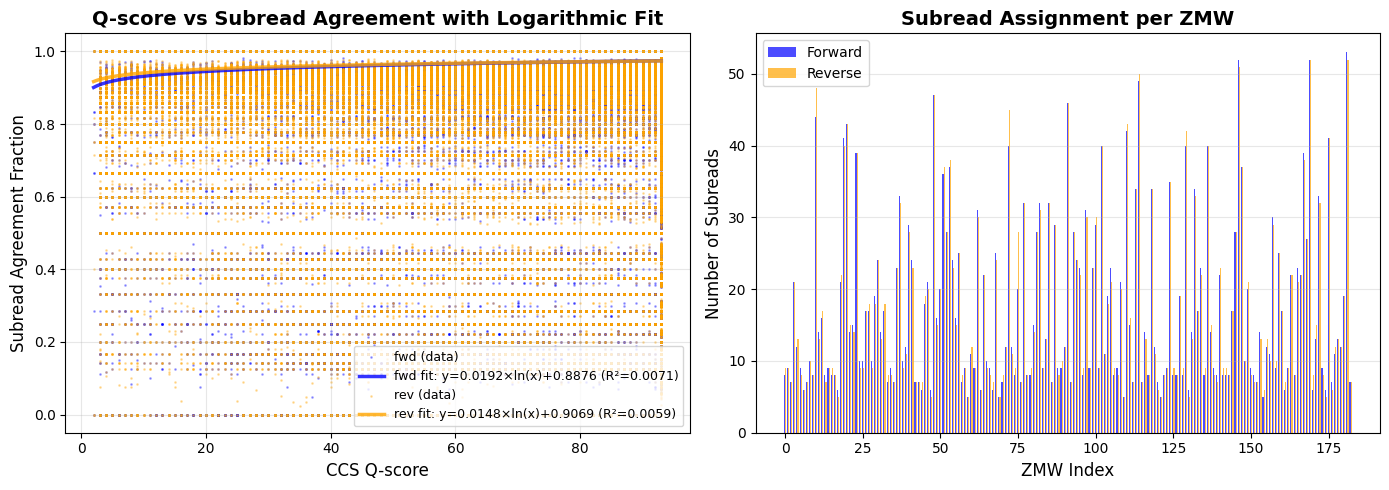

✓ Saved: testing/2D_dataset/hellinger_analysis_filtered/plot1_qscore_and_assignment.png

Subread assignment statistics:
  Mean forward per ZMW: 17.5
  Mean reverse per ZMW: 17.5

Logarithmic fit results:
  fwd: Agreement = 0.0192×ln(Q) + 0.8876  (R² = 0.0071)
  rev: Agreement = 0.0148×ln(Q) + 0.9069  (R² = 0.0059)


In [13]:
# Count subreads per zmw_strand
subread_counts = pd.DataFrame(assigned_subreads).groupby(['zmw', 'strand']).size().reset_index(name='n_subreads')

# Define logarithmic function for fitting
def log_func(x, a, b):
    """Logarithmic function: y = a * ln(x) + b"""
    return a * np.log(x) + b

# Prepare data and fit for each strand
fit_params = {}
for strand in ['fwd', 'rev']:
    data = df_hellinger[df_hellinger['strand'] == strand]
    # Filter valid data (q_score > 0 to avoid log issues)
    valid_data = data[(data['q_score'] > 0) & (data['agreement_fraction'].notna())].copy()
    
    if len(valid_data) > 10:  # Need enough points to fit
        try:
            # Fit logarithmic curve
            popt, pcov = curve_fit(log_func, valid_data['q_score'], valid_data['agreement_fraction'])
            
            # Calculate R² (coefficient of determination)
            y_pred = log_func(valid_data['q_score'], *popt)
            residuals = valid_data['agreement_fraction'] - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((valid_data['agreement_fraction'] - valid_data['agreement_fraction'].mean())**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_params[strand] = {
                'a': popt[0],
                'b': popt[1],
                'r2': r_squared
            }
        except:
            fit_params[strand] = None
    else:
        fit_params[strand] = None

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Q-score vs agreement fraction with logarithmic fit
ax = axes[0]

for strand, color in [('fwd', 'blue'), ('rev', 'orange')]:
    data = df_hellinger[df_hellinger['strand'] == strand]
    
    # Scatter plot
    ax.scatter(data['q_score'], data['agreement_fraction'], 
              alpha=0.3, s=1, color=color, label=f'{strand} (data)', rasterized=True)
    
    # Add logarithmic fit line if available
    if fit_params[strand] is not None:
        params = fit_params[strand]
        # Generate smooth curve
        q_range = np.linspace(data['q_score'].min(), data['q_score'].max(), 200)
        q_range = q_range[q_range > 0]  # Ensure positive values for log
        agreement_fit = log_func(q_range, params['a'], params['b'])
        
        # Plot fit line
        ax.plot(q_range, agreement_fit, color=color, linewidth=2.5, alpha=0.8,
               label=f"{strand} fit: y={params['a']:.4f}×ln(x)+{params['b']:.4f} (R²={params['r2']:.4f})")

ax.set_xlabel('CCS Q-score', fontsize=12)
ax.set_ylabel('Subread Agreement Fraction', fontsize=12)
ax.set_title('Q-score vs Subread Agreement with Logarithmic Fit', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='lower right')
ax.grid(alpha=0.3)

# Right: Subread assignment histogram
ax = axes[1]
subread_pivot = subread_counts.pivot(index='zmw', columns='strand', values='n_subreads').fillna(0)

x = np.arange(len(subread_pivot))
width = 0.35

ax.bar(x - width/2, subread_pivot['fwd'], width, label='Forward', color='blue', alpha=0.7)
ax.bar(x + width/2, subread_pivot['rev'], width, label='Reverse', color='orange', alpha=0.7)

ax.set_xlabel('ZMW Index', fontsize=12)
ax.set_ylabel('Number of Subreads', fontsize=12)
ax.set_title('Subread Assignment per ZMW', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot1_path = hellinger_output_dir / 'plot1_qscore_and_assignment.png'
plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {plot1_path}")
print(f"\nSubread assignment statistics:")
print(f"  Mean forward per ZMW: {subread_pivot['fwd'].mean():.1f}")
print(f"  Mean reverse per ZMW: {subread_pivot['rev'].mean():.1f}")

print(f"\nLogarithmic fit results:")
for strand in ['fwd', 'rev']:
    if fit_params[strand] is not None:
        p = fit_params[strand]
        print(f"  {strand}: Agreement = {p['a']:.4f}×ln(Q) + {p['b']:.4f}  (R² = {p['r2']:.4f})")
    else:
        print(f"  {strand}: Fit failed (insufficient data)")

## 9. PLOT 2: Hellinger Distance Difference Between Strands at Each Position

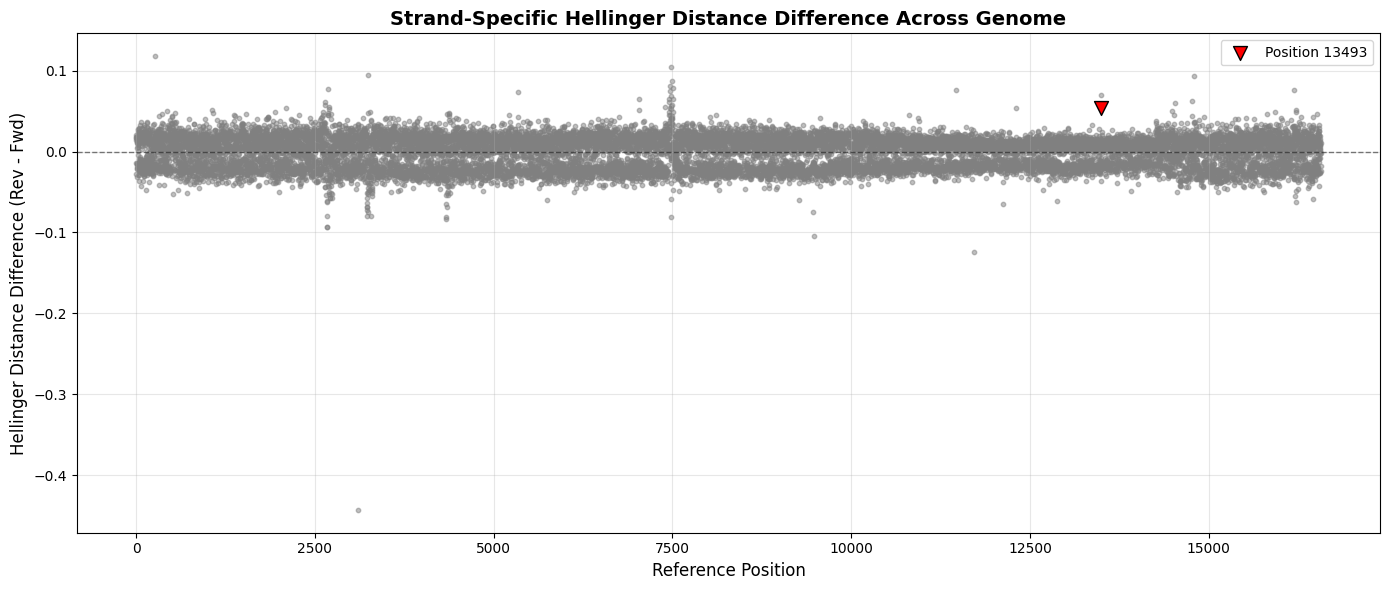

✓ Saved: testing/2D_dataset/hellinger_analysis_filtered/plot2_hellinger_difference_by_position.png

Position 13493:
  Hellinger difference (Rev - Fwd): 0.0542
  Percentile: 99.8%


In [14]:
# For each position, calculate mean Hellinger distance for forward and reverse strands
hellinger_by_position = df_hellinger.groupby(['ref_pos', 'strand'])['hellinger_distance'].mean().unstack(fill_value=np.nan)

# Calculate difference (reverse - forward)
hellinger_by_position['hellinger_diff'] = hellinger_by_position['rev'] - hellinger_by_position['fwd']

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

valid_positions = hellinger_by_position.dropna(subset=['hellinger_diff'])
ax.scatter(valid_positions.index, valid_positions['hellinger_diff'], 
          alpha=0.5, s=10, color='gray', rasterized=True)

# Highlight position 13493
if TARGET_POSITION in valid_positions.index:
    ax.scatter([TARGET_POSITION], [valid_positions.loc[TARGET_POSITION, 'hellinger_diff']], 
              s=100, color='red', marker='v', edgecolor='black', linewidth=1,
              label=f'Position {TARGET_POSITION}', zorder=10)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Reference Position', fontsize=12)
ax.set_ylabel('Hellinger Distance Difference (Rev - Fwd)', fontsize=12)
ax.set_title('Strand-Specific Hellinger Distance Difference Across Genome', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plot2_path = hellinger_output_dir / 'plot2_hellinger_difference_by_position.png'
plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {plot2_path}")

if TARGET_POSITION in valid_positions.index:
    print(f"\nPosition {TARGET_POSITION}:")
    print(f"  Hellinger difference (Rev - Fwd): {valid_positions.loc[TARGET_POSITION, 'hellinger_diff']:.4f}")
    print(f"  Percentile: {(valid_positions['hellinger_diff'] < valid_positions.loc[TARGET_POSITION, 'hellinger_diff']).mean()*100:.1f}%")

## 10. PLOT 3: Hellinger Distance at Position 13493

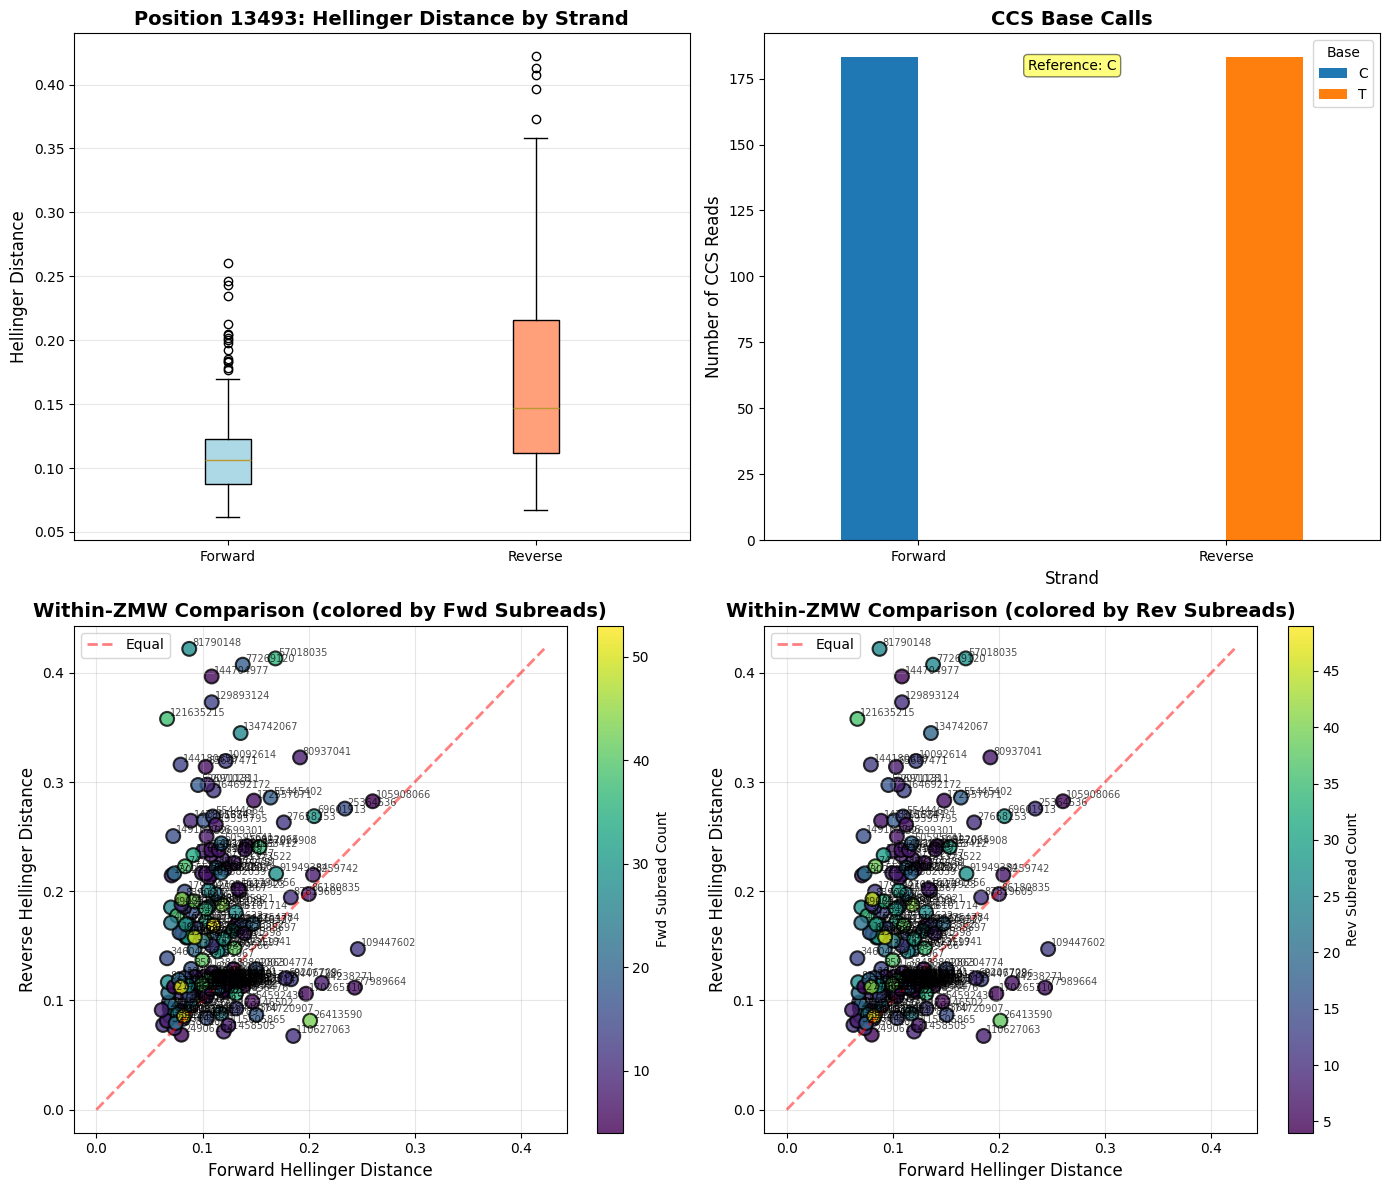

✓ Saved: testing/2D_dataset/hellinger_analysis_filtered/plot3_position_13493_hellinger_analysis.png

Position 13493 summary:
  Total CCS reads: 366
  Forward: 183 (mean Hellinger = 0.1130)
  Reverse: 183 (mean Hellinger = 0.1673)
  ZMWs with both strands: 183
  Reverse > Forward: 150/183 ZMWs
  Mean Hellinger difference (Rev - Fwd): 0.0542
  Fwd subread count range: 4 - 53
  Rev subread count range: 4 - 49


In [15]:
# Extract position 13493 data
pos_13493 = df_hellinger[df_hellinger['ref_pos'] == TARGET_POSITION].copy()

# Prepare for within-ZMW comparison
pos_13493_fwd = pos_13493[pos_13493['strand'] == 'fwd'].copy()
pos_13493_rev = pos_13493[pos_13493['strand'] == 'rev'].copy()

# Merge on ZMW
pos_13493_paired = pos_13493_fwd.merge(
    pos_13493_rev, on='zmw', suffixes=('_fwd', '_rev'), how='inner'
)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top Left: Boxplot comparing forward vs reverse
ax = axes[0, 0]
data_to_plot = [
    pos_13493_fwd['hellinger_distance'].dropna(),
    pos_13493_rev['hellinger_distance'].dropna()
]
bp = ax.boxplot(data_to_plot, labels=['Forward', 'Reverse'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightsalmon')
ax.set_ylabel('Hellinger Distance', fontsize=12)
ax.set_title(f'Position {TARGET_POSITION}: Hellinger Distance by Strand', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Top Right: Bar plot showing CCS base calls
ax = axes[0, 1]
base_calls = pos_13493.groupby(['strand', 'ccs_base']).size().unstack(fill_value=0)
base_calls.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_xlabel('Strand', fontsize=12)
ax.set_ylabel('Number of CCS Reads', fontsize=12)
ax.set_title('CCS Base Calls', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Forward', 'Reverse'], rotation=0)
ax.legend(title='Base')

# Add reference annotation
ref_base = ref_seq[TARGET_POSITION]
ax.text(0.5, 0.95, f'Reference: {ref_base}', 
       transform=ax.transAxes, ha='center', va='top',
       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Bottom Left: Within-ZMW scatter colored by Forward subread count
ax = axes[1, 0]
if len(pos_13493_paired) > 0:
    scatter = ax.scatter(pos_13493_paired['hellinger_distance_fwd'], 
              pos_13493_paired['hellinger_distance_rev'],
              c=pos_13493_paired['total_subreads_fwd'],
              cmap='viridis',
              s=100, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Fwd Subread Count', fontsize=10)
    
    # Diagonal line
    max_val = max(pos_13493_paired['hellinger_distance_fwd'].max(), 
                  pos_13493_paired['hellinger_distance_rev'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.5, label='Equal')
    
    # Add ZMW labels
    for _, row in pos_13493_paired.iterrows():
        ax.annotate(f"{row['zmw']}", 
                   (row['hellinger_distance_fwd'], row['hellinger_distance_rev']),
                   fontsize=7, alpha=0.7, xytext=(2, 2), textcoords='offset points')
    
    ax.set_xlabel('Forward Hellinger Distance', fontsize=12)
    ax.set_ylabel('Reverse Hellinger Distance', fontsize=12)
    ax.set_title('Within-ZMW Comparison (colored by Fwd Subreads)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No paired data', ha='center', va='center', transform=ax.transAxes)

# Bottom Right: Within-ZMW scatter colored by Reverse subread count
ax = axes[1, 1]
if len(pos_13493_paired) > 0:
    scatter = ax.scatter(pos_13493_paired['hellinger_distance_fwd'], 
              pos_13493_paired['hellinger_distance_rev'],
              c=pos_13493_paired['total_subreads_rev'],
              cmap='viridis',
              s=100, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Rev Subread Count', fontsize=10)
    
    # Diagonal line
    max_val = max(pos_13493_paired['hellinger_distance_fwd'].max(), 
                  pos_13493_paired['hellinger_distance_rev'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.5, label='Equal')
    
    # Add ZMW labels
    for _, row in pos_13493_paired.iterrows():
        ax.annotate(f"{row['zmw']}", 
                   (row['hellinger_distance_fwd'], row['hellinger_distance_rev']),
                   fontsize=7, alpha=0.7, xytext=(2, 2), textcoords='offset points')
    
    ax.set_xlabel('Forward Hellinger Distance', fontsize=12)
    ax.set_ylabel('Reverse Hellinger Distance', fontsize=12)
    ax.set_title('Within-ZMW Comparison (colored by Rev Subreads)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No paired data', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plot3_path = hellinger_output_dir / 'plot3_position_13493_hellinger_analysis.png'
plt.savefig(plot3_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {plot3_path}")

print(f"\nPosition {TARGET_POSITION} summary:")
print(f"  Total CCS reads: {len(pos_13493)}")
print(f"  Forward: {len(pos_13493_fwd)} (mean Hellinger = {pos_13493_fwd['hellinger_distance'].mean():.4f})")
print(f"  Reverse: {len(pos_13493_rev)} (mean Hellinger = {pos_13493_rev['hellinger_distance'].mean():.4f})")
print(f"  ZMWs with both strands: {len(pos_13493_paired)}")

if len(pos_13493_paired) > 0:
    pos_13493_paired['hellinger_diff'] = pos_13493_paired['hellinger_distance_rev'] - pos_13493_paired['hellinger_distance_fwd']
    n_rev_higher = (pos_13493_paired['hellinger_diff'] > 0).sum()
    print(f"  Reverse > Forward: {n_rev_higher}/{len(pos_13493_paired)} ZMWs")
    print(f"  Mean Hellinger difference (Rev - Fwd): {pos_13493_paired['hellinger_diff'].mean():.4f}")
    print(f"  Fwd subread count range: {pos_13493_paired['total_subreads_fwd'].min()} - {pos_13493_paired['total_subreads_fwd'].max()}")
    print(f"  Rev subread count range: {pos_13493_paired['total_subreads_rev'].min()} - {pos_13493_paired['total_subreads_rev'].max()}")

## 11. Save Output Files

In [16]:
# Save key datasets to hellinger_analysis directory
csv1_path = hellinger_output_dir / 'genome_wide_hellinger_distance.csv'
csv2_path = hellinger_output_dir / 'position_13493_all_reads.csv'
csv3_path = hellinger_output_dir / 'position_13493_within_zmw_comparison.csv'

df_hellinger.to_csv(csv1_path, index=False)
pos_13493.to_csv(csv2_path, index=False)

if len(pos_13493_paired) > 0:
    pos_13493_paired.to_csv(csv3_path, index=False)

print("✓ Saved output CSV files:")
print(f"  - {csv1_path}")
print(f"  - {csv2_path}")
if len(pos_13493_paired) > 0:
    print(f"  - {csv3_path}")

print("\nAnalysis complete!")
print(f"All outputs saved to: {hellinger_output_dir.absolute()}")

✓ Saved output CSV files:
  - testing/2D_dataset/hellinger_analysis_filtered/genome_wide_hellinger_distance.csv
  - testing/2D_dataset/hellinger_analysis_filtered/position_13493_all_reads.csv
  - testing/2D_dataset/hellinger_analysis_filtered/position_13493_within_zmw_comparison.csv

Analysis complete!
All outputs saved to: /project/testing/2D_dataset/hellinger_analysis_filtered
